## ***Preprocess pbmc10k dataset***

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Read processed .h5ad

adata_folder = "../raw_data/pbmc10k/filtered_feature_bc_matrix/"
adata = sc.read_10x_mtx(adata_folder)

In [41]:
adata.layers["raw_data"] = adata.X.copy()  # Store raw counts in a layer

In [42]:
# adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
# sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# adata.var['ribo'] = adata.var_names.str.startswith(('RPS', 'RPL'))
# sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

# adata = adata[adata.obs['mt_pct_content'] < 40, :]
# adata = adata[:, ~adata.var_names.str.startswith(('RPS', 'RPL'))]


sc.pp.filter_genes(adata, min_cells = np.exp(4))

In [43]:
sc.pp.normalize_total(adata, inplace = True)
adata.layers['norm_counts'] = adata.X.copy()

sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()

# sc.pp.scale(adata)
# adata.layers['scaled'] = adata.X.copy()

In [44]:
# Highly variable genes

sc.pp.highly_variable_genes(adata, layer = 'raw_data', n_top_genes = 4000, flavor = 'seurat_v3')

adata.var[['highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm']]

,highly_variable,highly_variable_rank,means,variances,variances_norm
Sox17,True,444.0,0.043894,0.250108,4.155574
Mrpl15,False,NaN,0.218159,0.316206,0.802016
Lypla1,False,NaN,0.166989,0.207528,0.743343
Tcea1,False,NaN,0.229336,0.291285,0.688606
Rgs20,False,NaN,0.016647,0.020348,0.918812
...,...,...,...,...,...
Vamp7,False,NaN,0.093546,0.107412,0.777246
Spry3,True,3895.0,0.001806,0.001960,0.998239
Tmlhe,False,NaN,0.001544,0.001542,0.947010
CAAA01147332.1,False,NaN,0.004109,0.004197,0.831496


In [45]:
# PCA

adata.X = adata.layers['log_norm'].copy()
sc.tl.pca(adata, n_comps=100, use_highly_variable=True)

adata.obsm['X_pca'] = adata.obsm['X_pca'][:, 0:30] # after getting optimal number of PCs
adata.varm['PCs'] = adata.varm['PCs'][:, 0:30]

df_loadings = pd.DataFrame(adata.varm['PCs'], 
                           index = adata.var.index, 
                           columns = ['PC-' + str(j) for j in range(30)])

df_loadings_hvg = df_loadings.loc[adata.var_names[adata.var['highly_variable']]]


In [46]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca', metric='euclidean', key_added='neighbors_30')
adata.obsp['neighbors_30_distances']
adata.obsp['neighbors_30_connectivities']

<38206x38206 sparse matrix of type '<class 'numpy.float32'>'
	with 1652584 stored elements in Compressed Sparse Row format>

In [47]:
adata

AnnData object with n_obs × n_vars = 38206 × 15100
    obs: 'sample', 'sample_id'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_data', 'norm_counts', 'log_norm'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities'

In [48]:
# UMAP

sc.tl.umap(adata, neighbors_key = 'neighbors_30', min_dist=0.1)

In [51]:
adata.var['gene_ids']

Sox17             ENSMUSG00000025902
Mrpl15            ENSMUSG00000033845
Lypla1            ENSMUSG00000025903
Tcea1             ENSMUSG00000033813
Rgs20             ENSMUSG00000002459
                         ...        
Vamp7             ENSMUSG00000051412
Spry3             ENSMUSG00000061654
Tmlhe             ENSMUSG00000079834
CAAA01147332.1    ENSMUSG00000095742
AC149090.1        ENSMUSG00000095041
Name: gene_ids, Length: 15100, dtype: object

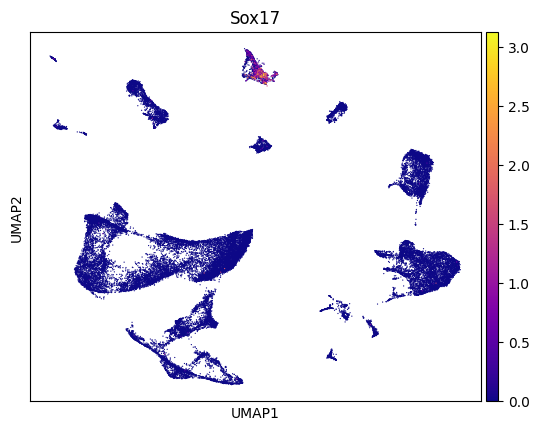

In [52]:
# genes = ['CD3E', 'CD8A', 'CD4', 'IL7R', 'MS4A1', 'CD19', 'LYZ', 'FCGR3A', 'NKG7', 'CST3', 'PPBP', 'PTPRC']
genes = ['Sox17']
sc.pl.umap(adata, color = genes, cmap = 'plasma', ncols = 3, use_raw=False)

In [55]:
import scipy

# Phenograph Clustering

sc.external.tl.phenograph(adata, clustering_algo='leiden', k=30, jaccard=True, primary_metric='euclidean', 
                          resolution_parameter=1)

adata.obsp['pheno_jaccard_ig'] = scipy.sparse.csr_matrix(adata.obsp['pheno_jaccard_ig'])

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.8010623455047607 seconds
Jaccard graph constructed in 6.495564222335815 seconds
Running Leiden optimization
Leiden completed in 8.726601362228394 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 18.50085210800171 seconds


In [57]:
adata

AnnData object with n_obs × n_vars = 38206 × 15100
    obs: 'sample', 'sample_id', 'pheno_leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30', 'umap', 'pheno_jaccard_q'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_data', 'norm_counts', 'log_norm'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'pheno_jaccard_ig'

In [62]:
adata.obs['condition'] = adata.obs['sample_id'].str.split('-').str[1]

... storing 'condition' as categorical


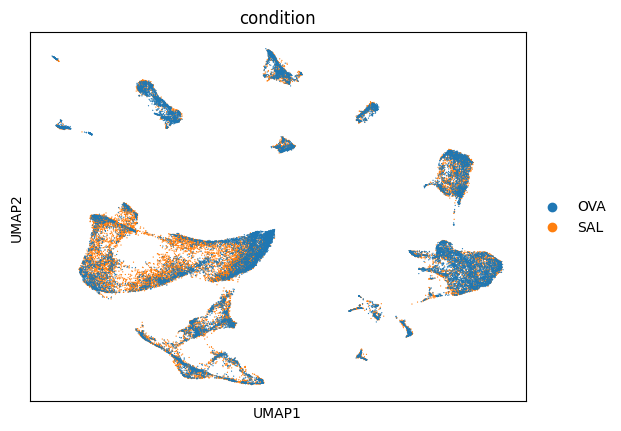

In [63]:
sc.pl.umap(adata, color = 'condition', cmap = 'plasma', ncols = 3, use_raw=False)

In [27]:
# Celltyping

In [28]:
# Manual 

genes = {'T-cells': ['CD3E', 'CD8A', 'CD4', 'IL7R'], 
         'B-cells': ['MS4A1', 'CD19'], 
         'Platelets': ['PPBP'], 
         'Monocytes': ['LYZ', 'FCGR3A'], 
         'NK-cells': ['NKG7'], 
         'Dendritic-cells': ['CST3', 'FCER1A']}

# Code for celltyping

In [29]:
# Automatic

import celltypist
from celltypist import models

In [ ]:
# to download an original CellTypist model 
# models.download_models() #all CellTypist Models
models.download_models(model = 'Immune_All_Low.pkl') #download one of them

📂 Storing models in /home/genos/.celltypist/data/models
💾 Total models to download: 1
⏩ Skipping [1/1]: Immune_All_Low.pkl (file exists)


In [31]:
adata_celltypist = sc.AnnData(adata.copy())
sc.pp.normalize_total(adata_celltypist, target_sum = 10000, inplace = True)
sc.pp.log1p(adata_celltypist)
adata_celltypist.obsm['X_umap'] = adata.obsm['X_umap']

predictions = celltypist.annotate(adata_celltypist, model = 'Immune_All_Low.pkl') #replace with path to the model, or model object

adata_preds = predictions.to_adata()

adata_preds.obs[['predicted_labels', 'conf_score']]

🔬 Input data has 10985 cells and 14916 genes
🔗 Matching reference genes in the model
🧬 4788 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


,predicted_labels,conf_score
AAACCCAGTATATGGA-1,Tcm/Naive helper T cells,0.999722
AAACCCAGTATCGTAC-1,Non-classical monocytes,0.550978
AAACCCAGTCGGTGAA-1,MAIT cells,0.999898
AAACCCAGTTAGAAAC-1,Classical monocytes,0.999829
AAACCCAGTTATCTTC-1,CD16+ NK cells,1.000000
...,...,...
TTTGTTGCAATAGGGC-1,Tcm/Naive cytotoxic T cells,0.999997
TTTGTTGCACAGAGAC-1,Tcm/Naive cytotoxic T cells,0.983362
TTTGTTGCACAGTCAT-1,Classical monocytes,0.999987
TTTGTTGTCCTAGCTC-1,Tem/Effector helper T cells,0.999724


In [32]:
# Automatic to cluster level

predictions2 = celltypist.annotate(adata_celltypist, model = 'Immune_All_Low.pkl', majority_voting=True, over_clustering = 'pheno_leiden') 

adata_preds2 = predictions2.to_adata()

adata_preds2.obs[['predicted_labels', 'conf_score', 'over_clustering', 'majority_voting']]

🔬 Input data has 10985 cells and 14916 genes
🔗 Matching reference genes in the model


🧬 4788 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


,predicted_labels,conf_score,over_clustering,majority_voting
AAACCCAGTATATGGA-1,Tcm/Naive helper T cells,0.999722,9,Tcm/Naive helper T cells
AAACCCAGTATCGTAC-1,Non-classical monocytes,0.550978,6,Classical monocytes
AAACCCAGTCGGTGAA-1,MAIT cells,0.999898,18,MAIT cells
AAACCCAGTTAGAAAC-1,Classical monocytes,0.999829,0,Classical monocytes
AAACCCAGTTATCTTC-1,CD16+ NK cells,1.000000,22,CD16+ NK cells
...,...,...,...,...
TTTGTTGCAATAGGGC-1,Tcm/Naive cytotoxic T cells,0.999997,3,Tcm/Naive cytotoxic T cells
TTTGTTGCACAGAGAC-1,Tcm/Naive cytotoxic T cells,0.983362,3,Tcm/Naive cytotoxic T cells
TTTGTTGCACAGTCAT-1,Classical monocytes,0.999987,5,Classical monocytes
TTTGTTGTCCTAGCTC-1,Tem/Effector helper T cells,0.999724,2,Tem/Effector helper T cells


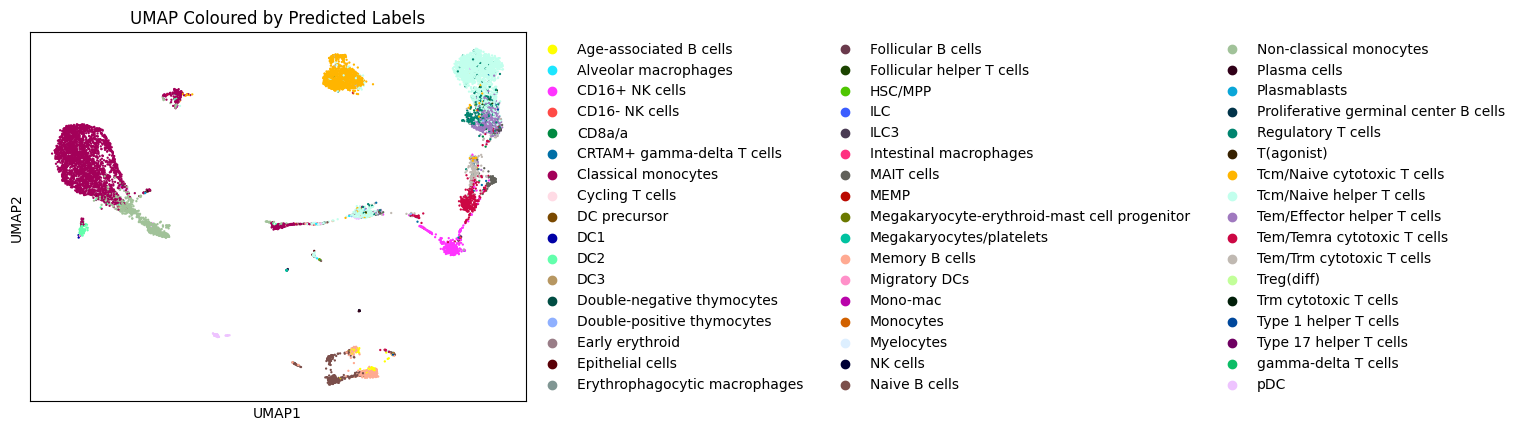

In [33]:
sc.pl.umap(adata_preds, color = ['predicted_labels'], title = "UMAP Coloured by Predicted Labels")

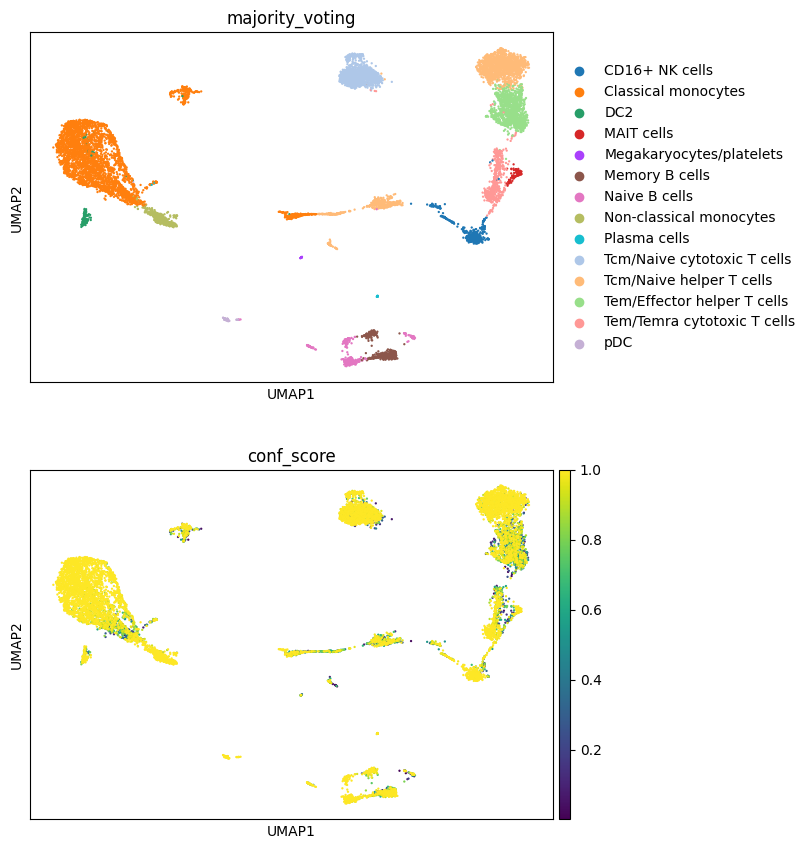

In [34]:
sc.pl.umap(adata_preds2, color = ['majority_voting', 'conf_score'], ncols = 1)

In [35]:
adata

AnnData object with n_obs × n_vars = 10985 × 14916
    obs: 'pheno_leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30', 'umap', 'pheno_jaccard_q'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_data', 'norm_counts', 'log_norm'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'pheno_jaccard_ig'

In [36]:
adata_preds2

AnnData object with n_obs × n_vars = 10985 × 14916
    obs: 'pheno_leiden', 'predicted_labels', 'conf_score', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30', 'umap', 'pheno_jaccard_q', 'predicted_labels_colors', 'majority_voting_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_data', 'norm_counts', 'log_norm'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'pheno_jaccard_ig'

In [37]:
# Export adata_preds2 to h5ad
processed_folder = "../processed_data/"
adata_preds2.write_h5ad(processed_folder + "pbmc10k_processed.h5ad", compression='gzip')

In [38]:
# SEACells

adata_preds2

AnnData object with n_obs × n_vars = 10985 × 14916
    obs: 'pheno_leiden', 'predicted_labels', 'conf_score', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30', 'umap', 'pheno_jaccard_q', 'predicted_labels_colors', 'majority_voting_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_data', 'norm_counts', 'log_norm'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'pheno_jaccard_ig'

## ***Preprocess GSE130973 dataset***

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil

In [2]:

# === Paths ===
cellranger_dir = "../raw_data/GSE130973/cellranger_output2/"  # or your actual folder

samples_ann = {
    "SRR9036398": {
        "sample_id": "o1",
        "condition": "old"
    },
    "SRR9036399": {
        "sample_id": "o2",
        "condition": "old"
    },
    "SRR9036400": {
        "sample_id": "o3",
        "condition": "old"
    },
    "SRR9036396": {
        "sample_id": "y1",
        "condition": "young"
    },
    "SRR9036397": {
        "sample_id": "y2",
        "condition": "young"
    }
}

samples = []

for sample_id in samples_ann.keys():
    s = sc.read_10x_mtx(cellranger_dir + sample_id + "/outs/filtered_feature_bc_matrix/", 
                        var_names='gene_symbols', cache=True)
    s.var_names_make_unique()
    s.obs['sample_id'] = samples_ann[sample_id]['sample_id']  # Assign sample_id based on the dictionary
    s.obs['condition'] = samples_ann[sample_id]['condition']  # Assign condition based on the dictionary
    samples.append(s)

# === Concatenate samples ===
adata = samples[0].concatenate(samples[1:], batch_key='sample_id', batch_categories=[v['sample_id'] for v in samples_ann.values()])

# # === Keep only genes from GRCh38 ===

# adata = adata[:, adata.var_names.str.startswith('GRCh38_')]
# adata.var.index = adata.var.index.str.replace('GRCh38_', '', regex=False)  # Remove 'GRCh38_' prefix from index
# adata.var['gene_ids'] = adata.var['gene_ids'].str.replace('GRCh38_', '', regex=False)  # Remove 'GRCh38_' prefix from gene_ids

adata.var['mt'] = adata.var_names.str.startswith(('MT-', 'mt-'))
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
row_sum_adata_mito = np.sum(adata[:, adata.var['mt']].X.toarray(), axis=1)
adata.obs['mt_pct_content'] = row_sum_adata_mito / adata.obs['total_counts'] * 100

adata.var['ribo'] = adata.var_names.str.startswith(('RPS', 'RPL', 'Rps', 'Rpl'))
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

adata = adata[adata.obs['mt_pct_content'] < 5, :]
adata = adata[:, ~adata.var_names.str.startswith(('RPS', 'RPL'))]

sc.pp.filter_genes(adata, min_cells = np.exp(4))

sc.pp.filter_cells(adata, max_genes = 7500)

/home/genos/gmunoz/SCRATCH/miniconda3/envs/sc_rna_env_python/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/genos/gmunoz/SCRATCH/miniconda3/envs/sc_rna_env_python/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [5]:
adata

AnnData object with n_obs × n_vars = 25539 × 18558
    obs: 'sample_id', 'condition', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'mt_pct_content', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'n_cells'

In [6]:
# adata.obs['total_counts'] = adata.X.sum(axis=1).A1
# adata = adata[np.argsort(adata.obs['total_counts'])[::-1][:15457], :].copy()

In [7]:
adata

AnnData object with n_obs × n_vars = 25539 × 18558
    obs: 'sample_id', 'condition', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'mt_pct_content', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'n_cells'

In [8]:
adata.layers["raw_data"] = adata.X.copy()  # Store raw counts in a layer

In [ ]:
# adata.var['mt'] = adata.var_names.str.startswith(('MT-', 'mt-'))
# sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# row_sum_adata_mito = np.sum(adata[:, adata.var['mt']].X.toarray(), axis=1)
# adata.obs['mt_pct_content'] = row_sum_adata_mito / adata.obs['total_counts'] * 100

# adata.var['ribo'] = adata.var_names.str.startswith(('RPS', 'RPL', 'Rps', 'Rpl'))
# sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

# adata = adata[adata.obs['mt_pct_content'] < 40, :]
# adata = adata[:, ~adata.var_names.str.startswith(('RPS', 'RPL'))]

# sc.pp.filter_genes(adata, min_cells = np.exp(4))

In [9]:
sc.pp.normalize_total(adata, inplace = True)
adata.layers['norm_counts'] = adata.X.copy()

sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()

sc.pp.scale(adata)
adata.layers['scaled'] = adata.X.copy()

In [10]:
# Highly variable genes

sc.pp.highly_variable_genes(adata, layer = 'raw_data', n_top_genes = 2000, flavor = 'seurat_v3')

In [11]:
# PCA

adata.X = adata.layers['log_norm'].copy()
sc.tl.pca(adata, n_comps=100, use_highly_variable=True)

adata.obsm['X_pca'] = adata.obsm['X_pca'][:, 0:30] # after getting optimal number of PCs
adata.varm['PCs'] = adata.varm['PCs'][:, 0:30]

df_loadings = pd.DataFrame(adata.varm['PCs'], 
                           index = adata.var.index, 
                           columns = ['PC-' + str(j) for j in range(30)])

df_loadings_hvg = df_loadings.loc[adata.var_names[adata.var['highly_variable']]]


In [12]:
import harmonypy as hm
import numpy as np

# Run Harmony
ho = hm.run_harmony(adata.obsm['X_pca'], adata.obs, 'sample_id')

# Store the Harmony-corrected PCA
adata.obsm['X_pca_harmony'] = ho.Z_corr.T


2025-07-15 05:41:41,740 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


2025-07-15 05:41:44,047 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-07-15 05:41:44,110 - harmonypy - INFO - Iteration 1 of 10
2025-07-15 05:41:47,961 - harmonypy - INFO - Iteration 2 of 10
2025-07-15 05:41:51,710 - harmonypy - INFO - Iteration 3 of 10
2025-07-15 05:41:55,756 - harmonypy - INFO - Iteration 4 of 10
2025-07-15 05:41:59,899 - harmonypy - INFO - Iteration 5 of 10
2025-07-15 05:42:02,477 - harmonypy - INFO - Converged after 5 iterations


In [14]:
import scipy

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.35743093490600586 seconds
Jaccard graph constructed in 1.9631123542785645 seconds
Running Leiden optimization
Leiden completed in 3.494568109512329 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 6.909095525741577 seconds


/home/genos/gmunoz/SCRATCH/miniconda3/envs/sc_rna_env_python/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/genos/gmunoz/SCRATCH/miniconda3/envs/sc_rna_env_python/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/genos/gmunoz/SCRATCH/miniconda3/envs/sc_rna_env_python/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


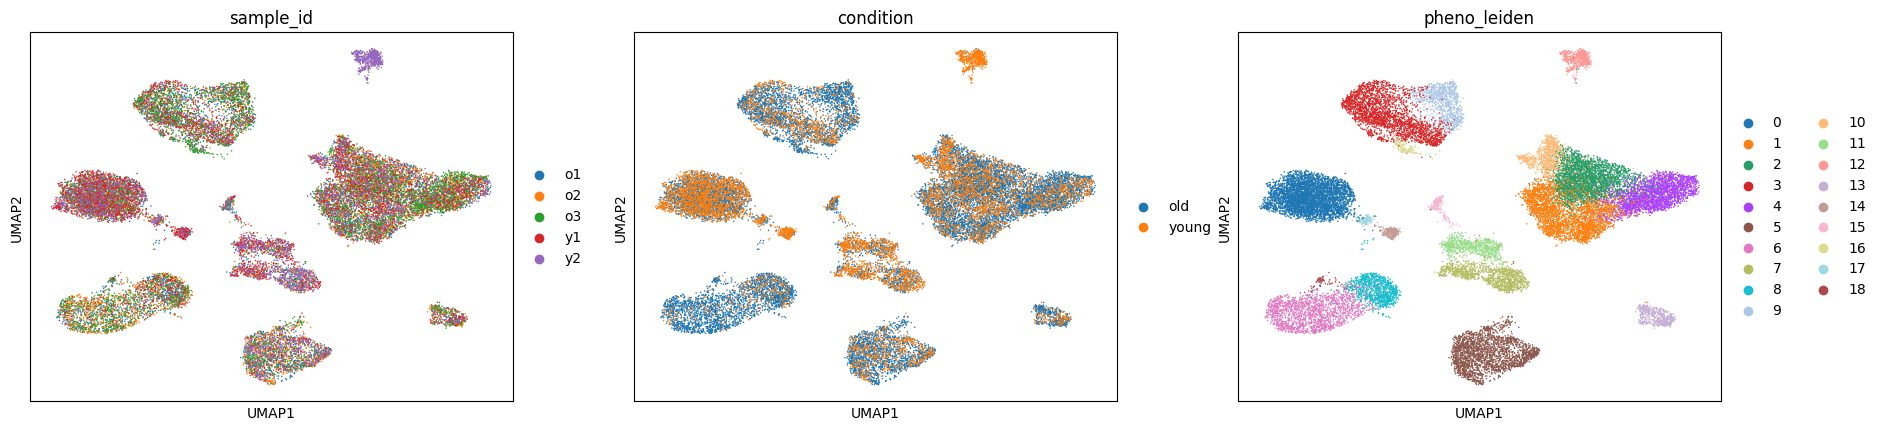

In [16]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_neighbors=20)
sc.tl.umap(adata)
# sc.tl.leiden(adata)
sc.external.tl.phenograph(adata, clustering_algo='leiden', k=30, jaccard=True, primary_metric='euclidean', 
                          resolution_parameter=0.4)

adata.obsp['pheno_jaccard_ig'] = scipy.sparse.csr_matrix(adata.obsp['pheno_jaccard_ig'])

# Visualization
sc.pl.umap(adata, color=["sample_id", "condition", "pheno_leiden"])

In [17]:
adata

AnnData object with n_obs × n_vars = 25539 × 18558
    obs: 'sample_id', 'condition', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'mt_pct_content', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'pheno_leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'n_cells', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'pheno_jaccard_q', 'sample_id_colors', 'condition_colors', 'pheno_leiden_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'raw_data', 'norm_counts', 'log_norm', 'scaled'
    obsp: 'distances', 'connectivities', 'pheno_jaccard_ig'

In [71]:
# UMAP

sc.tl.umap(adata, neighbors_key = 'neighbors_30', min_dist=0.1)

/home/genos/gmunoz/SCRATCH/miniconda3/envs/sc_rna_env_python/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/genos/gmunoz/SCRATCH/miniconda3/envs/sc_rna_env_python/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


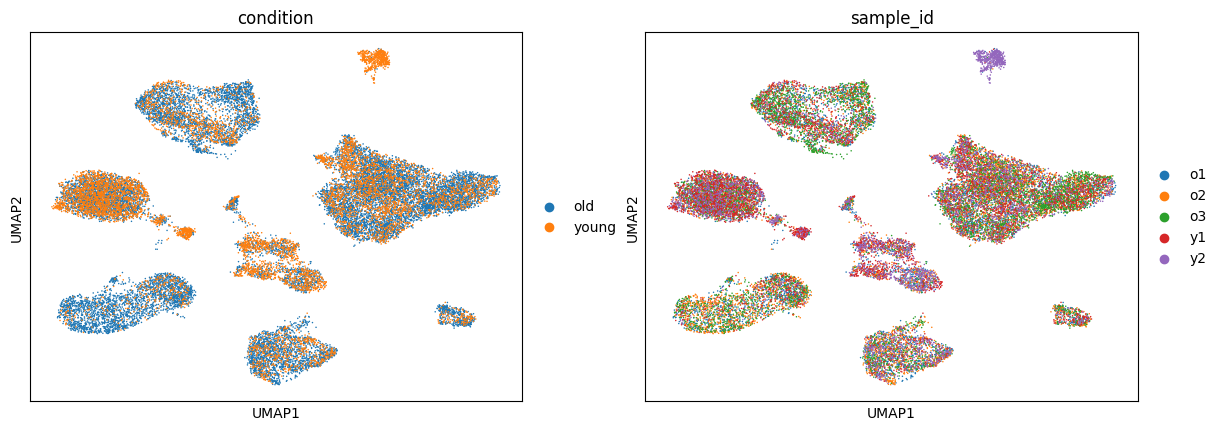

In [18]:
sc.pl.umap(adata, color = ['condition', 'sample_id'], cmap = 'plasma', ncols = 3)

In [54]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Step 1: Run DE if not already done
sc.tl.rank_genes_groups(adata, groupby='pheno_leiden', method='wilcoxon')

# Step 2: Extract top 5 genes per cluster
top_n = 5
groups = adata.uns['rank_genes_groups']['names'].dtype.names

top_genes = []
for group in groups:
    top = adata.uns['rank_genes_groups']['names'][group][:top_n]
    top_genes.extend(top)
top_genes = list(dict.fromkeys(top_genes))  # Remove duplicates

# Step 3: Custom colormap from magenta (-2) → white (0) → yellow (+2)
colors = ["magenta", "black", "yellow"]
custom_cmap = LinearSegmentedColormap.from_list("magenta_yellow", colors)


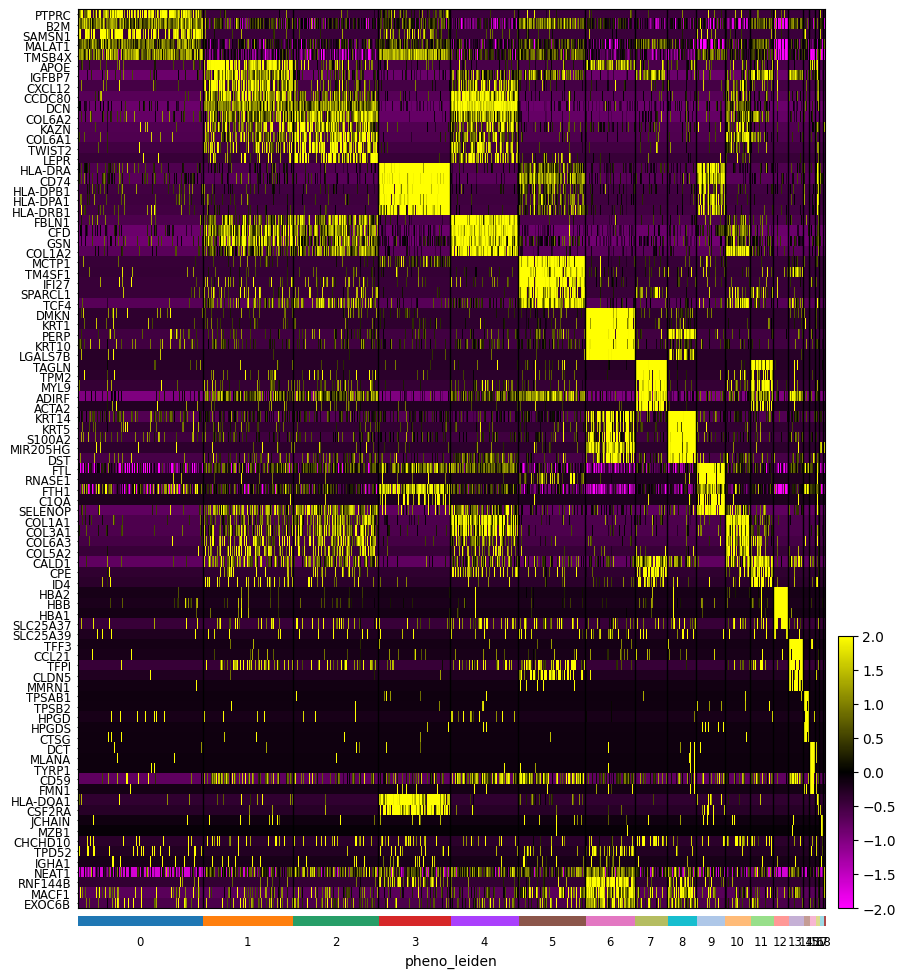

In [ ]:
sc.pl.heatmap(
    adata,
    var_names=top_genes,
    groupby='pheno_leiden',
    layer='scaled',  # <- important
    swap_axes=True,
    show_gene_labels=True,
    cmap=custom_cmap,  # your magenta to yellow colormap
    vmin=-2, vmax=2,
    dendrogram=False,
    figsize=(10, 12)
)



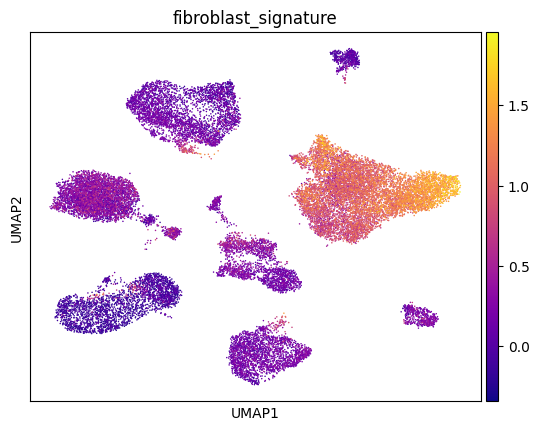

In [21]:
signature_genes = [
    'LUM', 'DCN', 'VIM', 'PDGFRA', 'COL1A2', 'CD3D'
]

sc.tl.score_genes(adata, gene_list=signature_genes, score_name='fibroblast_signature')
sc.pl.umap(adata, color='fibroblast_signature', cmap='plasma', ncols=1)

In [117]:
import scipy

# Phenograph Clustering

sc.external.tl.phenograph(adata, clustering_algo='leiden', k=30, jaccard=True, primary_metric='euclidean', 
                          resolution_parameter=1)

adata.obsp['pheno_jaccard_ig'] = scipy.sparse.csr_matrix(adata.obsp['pheno_jaccard_ig'])

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.606945276260376 seconds
Jaccard graph constructed in 3.4936769008636475 seconds
Running Leiden optimization
Leiden completed in 12.343292236328125 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 18.651225805282593 seconds


In [118]:
adata

AnnData object with n_obs × n_vars = 36775 × 18602
    obs: 'sample_id', 'condition', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'mt_pct_content', 'total_counts_ribo', 'pct_counts_ribo', 'leiden', 'fibroblast_signature', 'pheno_leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'sample_id_colors', 'condition_colors', 'leiden_colors', 'rank_genes_groups', 'pheno_jaccard_q'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'raw_data', 'norm_counts', 'log_norm'
    obsp: 'distances', 'connectivities', 'pheno_jaccard_ig'

In [ ]:
# Celltyping

In [ ]:
# Manual 

genes = {'T-cells': ['CD3E', 'CD8A', 'CD4', 'IL7R'], 
         'B-cells': ['MS4A1', 'CD19'], 
         'Platelets': ['PPBP'], 
         'Monocytes': ['LYZ', 'FCGR3A'], 
         'NK-cells': ['NKG7'], 
         'Dendritic-cells': ['CST3', 'FCER1A']}

# Code for celltyping

In [24]:
# Automatic

import celltypist
from celltypist import models

In [178]:
# to download an original CellTypist model 
# models.download_models() #all CellTypist Models
models.download_models(model = 'Adult_Human_Skin.pkl') #download one of them
models.download_models(model = 'Fetal_Human_Skin.pkl') #download one of them

📂 Storing models in /home/genos/.celltypist/data/models
💾 Total models to download: 1
⏩ Skipping [1/1]: Adult_Human_Skin.pkl (file exists)
📂 Storing models in /home/genos/.celltypist/data/models
💾 Total models to download: 1
⏩ Skipping [1/1]: Fetal_Human_Skin.pkl (file exists)


In [30]:
adata_celltypist = sc.AnnData(adata.copy())
sc.pp.normalize_total(adata_celltypist, target_sum = 10000, inplace = True)
sc.pp.log1p(adata_celltypist)
adata_celltypist.obsm['X_umap'] = adata.obsm['X_umap']

predictions = celltypist.annotate(adata_celltypist, model = 'Adult_Human_Skin.pkl')

adata_preds = predictions.to_adata()

adata_preds.obs[['predicted_labels', 'conf_score']]

🔬 Input data has 25539 cells and 18558 genes
🔗 Matching reference genes in the model
🧬 3063 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


,predicted_labels,conf_score
AAACCTGAGTGAACGC-1-o1,VE3,0.292762
AAACCTGCAAACTGCT-1-o1,F2,0.999863
AAACCTGCAGCTGTAT-1-o1,VE3,0.155331
AAACCTGCATACTACG-1-o1,DC2,0.126443
AAACCTGGTTAAGAAC-1-o1,DC2,0.754341
...,...,...
TTTGTCAGTTTGACAC-1-y2,F2,1.000000
TTTGTCATCACTCTTA-1-y2,Differentiated_KC,0.458331
TTTGTCATCATCGCTC-1-y2,Macro_2,0.987703
TTTGTCATCCAAGTAC-1-y2,VE2,0.994999


In [31]:
# Automatic to cluster level

predictions2 = celltypist.annotate(adata_celltypist, model = 'Adult_Human_Skin.pkl', majority_voting=True, over_clustering = 'pheno_leiden') 

adata_preds2 = predictions2.to_adata()

adata_preds2.obs[['predicted_labels', 'conf_score', 'over_clustering', 'majority_voting']]

🔬 Input data has 25539 cells and 18558 genes
🔗 Matching reference genes in the model


🧬 3063 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


,predicted_labels,conf_score,over_clustering,majority_voting
AAACCTGAGTGAACGC-1-o1,VE3,0.292762,5,VE3
AAACCTGCAAACTGCT-1-o1,F2,0.999863,1,F2
AAACCTGCAGCTGTAT-1-o1,VE3,0.155331,5,VE3
AAACCTGCATACTACG-1-o1,DC2,0.126443,3,DC2
AAACCTGGTTAAGAAC-1-o1,DC2,0.754341,3,DC2
...,...,...,...,...
TTTGTCAGTTTGACAC-1-y2,F2,1.000000,1,F2
TTTGTCATCACTCTTA-1-y2,Differentiated_KC,0.458331,0,Th
TTTGTCATCATCGCTC-1-y2,Macro_2,0.987703,9,Macro_2
TTTGTCATCCAAGTAC-1-y2,VE2,0.994999,5,VE3


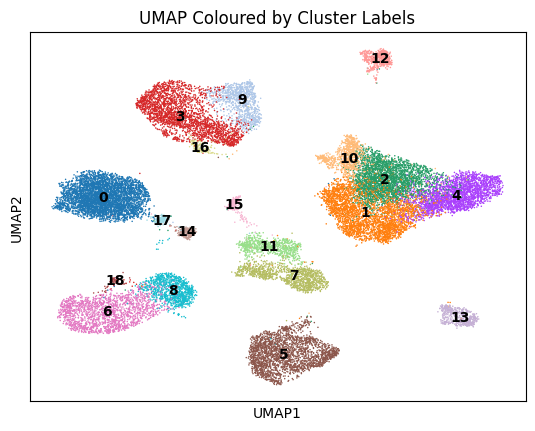

In [32]:
# no legend but number over clusters

sc.pl.umap(adata_preds, color = ['pheno_leiden'], title = "UMAP Coloured by Cluster Labels",
           legend_loc="on data")

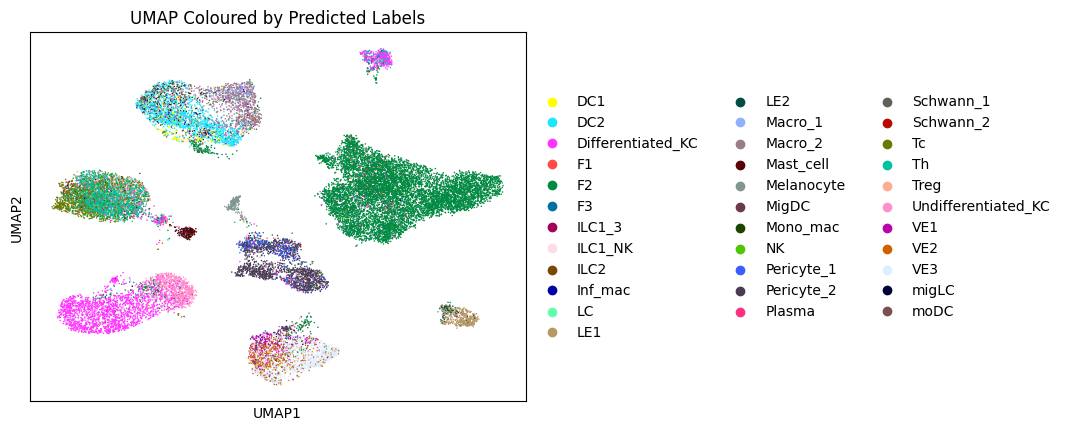

In [33]:
sc.pl.umap(adata_preds, color = ['predicted_labels'], title = "UMAP Coloured by Predicted Labels")

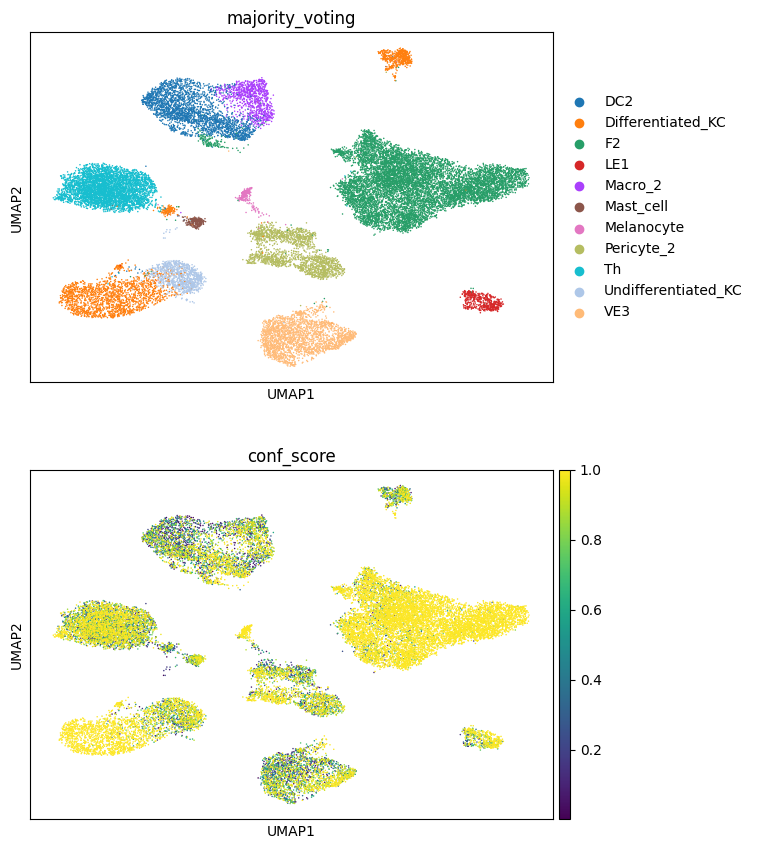

In [34]:
sc.pl.umap(adata_preds2, color = ['majority_voting', 'conf_score'], ncols = 1)

In [33]:
adata

AnnData object with n_obs × n_vars = 16062 × 14374
    obs: 'pheno_leiden'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30', 'umap', 'pheno_jaccard_q'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_data', 'norm_counts', 'log_norm'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'pheno_jaccard_ig'

In [34]:
adata_preds2

AnnData object with n_obs × n_vars = 16062 × 14374
    obs: 'pheno_leiden', 'predicted_labels', 'conf_score', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30', 'umap', 'pheno_jaccard_q', 'predicted_labels_colors', 'majority_voting_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_data', 'norm_counts', 'log_norm'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'pheno_jaccard_ig'

In [ ]:
# Export adata_preds2 to h5ad
# processed_folder = "../processed_data/"
# adata_preds2.write_h5ad(processed_folder + "pbmc10k_processed.h5ad", compression='gzip')

In [ ]:
# SEACells

adata_preds2

AnnData object with n_obs × n_vars = 10985 × 14916
    obs: 'pheno_leiden', 'predicted_labels', 'conf_score', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30', 'umap', 'pheno_jaccard_q', 'predicted_labels_colors', 'majority_voting_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_data', 'norm_counts', 'log_norm'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'pheno_jaccard_ig'